https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

In [3]:
%matplotlib inline
from matplotlib import pyplot
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score, f1_score,classification_report
from random import randint, shuffle
import os
import seaborn as sns

In [4]:
train_data = pd.read_csv('walmart/train.csv')

In [5]:
test_data = pd.read_csv('walmart/test.csv')

In [6]:
stores_data = pd.read_csv('walmart/stores.csv')

In [7]:
sampleSubmission_data = pd.read_csv('walmart/sampleSubmission.csv')

In [8]:
features_data = pd.read_csv('walmart/features.csv')

# データ詳細

In [9]:
train_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [89]:
train_data.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


In [10]:
test_data.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [11]:
stores_data.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [12]:
features_data.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [13]:
print(train_data.shape)
print(test_data.shape)
print(stores_data.shape)
print(features_data.shape)

(421570, 5)
(115064, 4)
(45, 3)
(8190, 12)


# 欠損値の確認

In [14]:
# 関数化
def isnull_check(data):
    col_names = data.columns
    for col_name in col_names:
        missing_num = sum(pd.isnull(data[col_name]))
    
        
        
    return print(col_names,missing_num)

In [15]:
isnull_check(data = train_data)
isnull_check(data = test_data)
isnull_check(data = sampleSubmission_data)
isnull_check(data = stores_data)
isnull_check(data = features_data)


Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object') 0
Index(['Store', 'Dept', 'Date', 'IsHoliday'], dtype='object') 0
Index(['Id', 'Weekly_Sales'], dtype='object') 0
Index(['Store', 'Type', 'Size'], dtype='object') 0
Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object') 0


# 欠損値はなし

# データの可視化

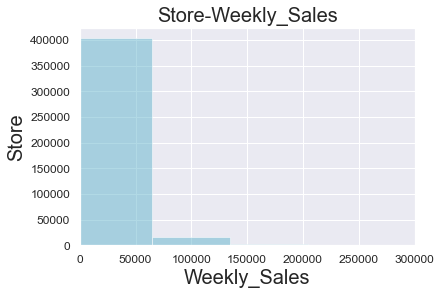

In [16]:
plt.xlim(0, 300000)                 # (1) x軸の表示範囲
# plt.ylim(0, 30)                 # (2) y軸の表示範囲
plt.title("Store-Weekly_Sales", fontsize=20)  # (3) タイトル
plt.xlabel("Weekly_Sales", fontsize=20)            # (4) x軸ラベル
plt.ylabel("Store", fontsize=20)      # (5) y軸ラベル
plt.grid(True)                            # (6) 目盛線の表示
plt.tick_params(labelsize = 12)    # (7) 目盛線のラベルサイズ 
 
# グラフの描画
plt.hist(train_data['Weekly_Sales'] , alpha=0.5, color= 'c') #(8) ヒストグラムの描画
plt.show()
 

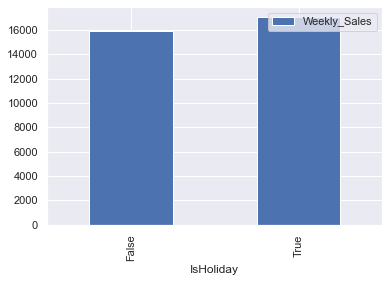

In [17]:
Weekly_Sales_by_IsHoliday = \
    train_data.groupby('IsHoliday').aggregate({'Weekly_Sales': np.mean}).reset_index()
Weekly_Sales_by_IsHoliday.plot.bar(x='IsHoliday')

In [18]:
train_date_sales = pd.pivot_table(
    train_data, 
    columns=["Date"],
    index="Store",
    values="Weekly_Sales",
    aggfunc=np.mean).reset_index()

In [19]:
train_date_sales.head()

Date,Store,2010-02-05,2010-02-12,2010-02-19,2010-02-26,2010-03-05,2010-03-12,2010-03-19,2010-03-26,2010-04-02,...,2012-08-24,2012-08-31,2012-09-07,2012-09-14,2012-09-21,2012-09-28,2012-10-05,2012-10-12,2012-10-19,2012-10-26
0,1,22516.313699,22804.964444,22081.755753,19579.549861,21298.721644,19719.747808,20451.608194,19505.971111,22152.337222,...,21043.977183,21973.380556,22763.936027,21075.400972,21213.043099,19685.743288,23205.360694,21548.942603,21240.405211,20745.274167
1,2,29273.828219,29691.798611,29102.075890,25549.277671,27274.152466,27645.608056,26658.505205,23975.312466,28697.051667,...,26433.635915,26672.373973,26743.339014,25205.647639,25766.417887,24256.535556,27754.458889,26037.604521,26028.033944,25837.441549
2,3,7101.880308,6573.890000,6486.802923,6463.569206,6590.508571,6003.135781,5774.286000,5713.480476,6613.975000,...,6546.820159,6594.173065,6378.589531,6574.018710,6577.652222,6090.828438,6930.588281,6320.067538,6633.016875,6334.885938
3,4,29248.546164,29177.431867,28080.277534,26023.362703,27375.797778,25949.645068,25640.937297,24144.373973,27112.974247,...,29112.899726,28905.296528,29111.023562,29414.647222,29436.646250,28558.031408,30692.158750,29625.362083,29538.969718,29855.478611
4,5,5115.695161,4797.318462,4668.424154,4158.178923,4513.370469,4795.057903,4543.651774,4407.789839,5178.218750,...,5174.699355,5649.869016,5748.342787,4758.740794,4877.885079,5002.285161,5623.742459,5083.522031,4973.938889,5154.044677


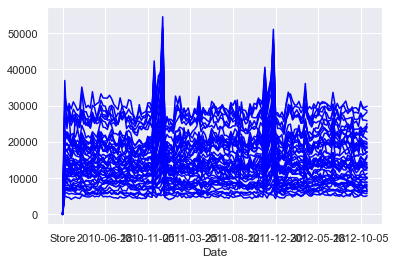

In [20]:
train_date_sales.T.plot(color='blue', alpha=1, legend=False)

In [21]:
train_data2 = train_data.copy()

In [22]:
train_data2['Date'] = pd.to_datetime(train_data2['Date'])

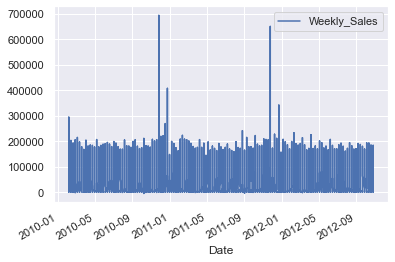

In [23]:
train_data2.plot(x = 'Date', y = 'Weekly_Sales')

StoreとDeptでデータを分けて、ランダムフォレストで予測するための前処理を行う

In [24]:
store1_tra = train_data[train_data['Store'] == 1] 

In [25]:
store1_1_tra = store1_tra[store1_tra['Dept'] == 1]

In [25]:
store1_1_tra.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [26]:
store1_1_tra['Date'] = pd.to_datetime(store1_1_tra['Date'])

C:\Users\81907\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


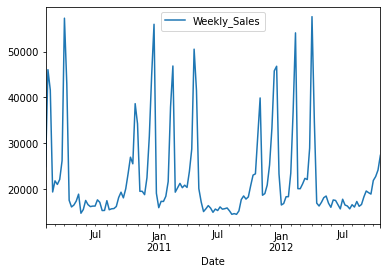

In [27]:
store1_1_tra.plot(x = 'Date', y = 'Weekly_Sales') 

ランダムフォレストで予測するために、週と月の特徴量を作成する

In [13]:
def get_week(x):
    return x.week

In [14]:
store1_1_tra.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [15]:
store1_1_tra['week'] = store1_1_tra['Date'].apply(get_week)

C:\Users\81907\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
store1_1_tra.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,week
0,1,1,2010-02-05,24924.50,False,5
1,1,1,2010-02-12,46039.49,True,6
2,1,1,2010-02-19,41595.55,False,7
3,1,1,2010-02-26,19403.54,False,8
4,1,1,2010-03-05,21827.90,False,9


In [17]:
def get_month(x):
    return x.month

In [18]:
store1_1_tra['month'] = store1_1_tra['Date'].apply(get_month)

C:\Users\81907\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
store1_1_tra.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,week,month
0,1,1,2010-02-05,24924.50,False,5,2
1,1,1,2010-02-12,46039.49,True,6,2
2,1,1,2010-02-19,41595.55,False,7,2
3,1,1,2010-02-26,19403.54,False,8,2
4,1,1,2010-03-05,21827.90,False,9,3


In [20]:
store1_1_tra_a = pd.get_dummies(store1_1_tra, columns = ['IsHoliday','week','month'])

In [21]:
store1_1_tra_a.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_False,IsHoliday_True,week_1,week_2,week_3,week_4,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,1,2010-02-05,24924.50,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2010-02-12,46039.49,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,2010-02-19,41595.55,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,2010-02-26,19403.54,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,2010-03-05,21827.90,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


目的関数と特徴量を定義する

In [22]:
target_col = 'Weekly_Sales'

In [24]:
exclude_cols = ['Store','Dept','Date','Weekly_Sales']

In [28]:
feature_cols = []
for col in store1_1_tra_a.columns:
    if col not in exclude_cols:
        feature_cols.append(col)

In [29]:
X = store1_1_tra_a[feature_cols]
y = store1_1_tra_a[target_col]

In [31]:
X.head()

,IsHoliday_False,IsHoliday_True,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [32]:
y.head()

0    24924.50
1    46039.49
2    41595.55
3    19403.54
4    21827.90
Name: Weekly_Sales, dtype: float64

データを学習とテストデータに分ける

In [34]:
X.shape

(143, 66)

データ数は143なので、
143 * 0.7 ≒100

In [35]:
train_rows = 100
X_train = X[:train_rows]
X_test = X[train_rows:]
y_train = y[:train_rows]
y_test = y[train_rows:]

In [38]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100, 66)
(43, 66)
(100,)
(43,)


ランダムフォレストで学習

In [39]:
rf = RandomForestRegressor(random_state=1234)
# train_dataで学習
rf.fit(X_train, y_train)
# 予測する
y_pred = rf.predict(X_test)

C:\Users\81907\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSEで精度算出

In [40]:
mse = mean_squared_error(y_pred, y_test)
print('RSME: ', np.sqrt(mse))

RSME:  5486.729215981526


予測値と実際の値をグラフ化する

In [63]:
y_graph = pd.DataFrame({'y_test': y_test, 'y_pred':y_pred})

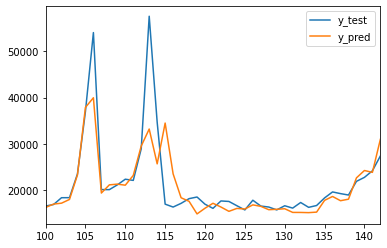

In [65]:
y_graph.plot()

# Storeごとにデータを分けてランダムフォレストで予測する

In [72]:
max(train_data["Dept"])

99

最初にstore1のDept1のデータを用意する

In [78]:
store1_tra_sales = store1_tra[store1_tra["Dept"]==1]["Weekly_Sales"]

In [79]:
store1_tra_sales.reset_index(drop=True)

0      24924.50
1      46039.49
2      41595.55
3      19403.54
4      21827.90
5      21043.39
6      22136.64
7      26229.21
8      57258.43
9      42960.91
10     17596.96
11     16145.35
12     16555.11
13     17413.94
14     18926.74
15     14773.04
16     15580.43
17     17558.09
18     16637.62
19     16216.27
20     16328.72
21     16333.14
22     17688.76
23     17150.84
24     15360.45
25     15381.82
26     17508.41
27     15536.40
28     15740.13
29     15793.87
         ...   
113    57592.12
114    34684.21
115    16976.19
116    16347.60
117    17147.44
118    18164.20
119    18517.79
120    16963.55
121    16065.49
122    17666.00
123    17558.82
124    16633.41
125    15722.82
126    17823.37
127    16566.18
128    16348.06
129    15731.18
130    16628.31
131    16119.92
132    17330.70
133    16286.40
134    16680.24
135    18322.37
136    19616.22
137    19251.50
138    18947.81
139    21904.47
140    22764.01
141    24185.27
142    27390.81
Name: Weekly_Sales, Leng

次にstore1のDept2以降を連結していく

In [80]:
for Dept_i in range(2, 100):
    store1_tra_temp = store1_tra[store1_tra['Dept'] == Dept_i]['Weekly_Sales']
    store1_tra_tepm_series = store1_tra_temp.reset_index(drop=True)
    store1_tra_sales = pd.concat([store1_tra_sales, store1_tra_tepm_series], axis = 1)    

In [82]:
store1_tra_sales.head()

,Weekly_Sales,Weekly_Sales,Weekly_Sales,Weekly_Sales,Weekly_Sales,Weekly_Sales,Weekly_Sales,Weekly_Sales,Weekly_Sales,Weekly_Sales,...,Weekly_Sales,Weekly_Sales,Weekly_Sales,Weekly_Sales,Weekly_Sales,Weekly_Sales,Weekly_Sales,Weekly_Sales,Weekly_Sales,Weekly_Sales
0,24924.50,50605.27,13740.12,39954.04,32229.38,5749.03,21084.08,40129.01,16930.99,30721.50,...,76419.47,62424.14,139884.94,64494.87,56655.39,106690.06,5265.09,32153.04,10891.37,0.01
1,46039.49,44682.74,10887.84,35351.21,29620.81,9135.00,18310.31,37334.83,16562.49,31494.77,...,79455.64,66937.00,143081.42,70202.02,62329.48,111390.36,33614.93,33874.47,16309.73,380.00
2,41595.55,47928.89,11523.47,36826.95,26468.27,6060.26,19985.20,38717.60,15880.85,29634.13,...,76091.36,63011.44,135066.75,62581.64,72212.32,107952.07,31829.94,31585.78,12087.95,50.00
3,19403.54,44292.87,11135.17,34660.16,24101.89,5244.56,17224.22,35318.20,15175.52,27921.96,...,71718.48,57335.17,125048.08,57630.02,55501.07,103652.58,32929.90,28457.31,10871.74,230.00
4,21827.90,48397.98,12275.58,38086.19,23082.14,4221.25,19659.70,38776.09,24064.70,33299.27,...,78081.85,62755.71,132945.44,63550.08,59201.37,112807.75,31662.07,31576.47,10903.65,50.00


In [91]:
# 欠損の確認
store1_tra_sales.isnull().sum()

Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales    143
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales     30
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
               ... 
Weekly_Sales    143
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales    143
Weekly_Sales      0
Weekly_Sales    143
Weekly_Sales    143
Weekly_Sales    140
Weekly_Sales    139
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales      0
Weekly_Sales    143
Weekly_Sales      0
Weekly_Sales    143
Weekly_Sales      0
Weekly_Sales    143


In [92]:
# 欠損を0で穴埋め
store1_tra_sales = store1_tra_sales.fillna(0)

データを学習とテストデータに分ける

In [93]:
store1_tra_sales.shape

(143, 99)

In [94]:
# target変数が変わるのでYと定義する
Y = store1_tra_sales

データ数は143なので、
143 * 0.7 ≒100

In [95]:
train_rows = 100
X_train = X[:train_rows]
X_test = X[train_rows:]
Y_train = Y[:train_rows]
Y_test = Y[train_rows:]

In [96]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(100, 66)
(43, 66)
(100, 99)
(43, 99)


ランダムフォレストで学習

In [105]:
rf2 = RandomForestRegressor(random_state=1234)
# train_dataで学習
rf2.fit(X_train, Y_train)
# 予測する
Y_pred = rf2.predict(X_test)

C:\Users\81907\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSEで精度算出

In [114]:
mse2 = mean_squared_error(Y_pred, Y_test)
print('RSME: ', np.sqrt(mse2))

RSME:  4304.534769504007


各DeptごとのRSMEを算出

In [108]:
# Y_testをnpに変換
Y_test_ar = np.array(Y_test)

In [112]:
for i in range(Y_pred.shape[1]):
    mse3 = mean_squared_error(Y_pred[:,i], Y_test_ar[:,i])
    print('RMSE:' + 'Dept' + str(i) + ':',np.sqrt(mse3))

RMSE:Dept0: 5550.708856631996
RMSE:Dept1: 2375.7326540774498
RMSE:Dept2: 3391.321207825172
RMSE:Dept3: 2830.218761365176
RMSE:Dept4: 4407.976530791722
RMSE:Dept5: 1422.4650282759085
RMSE:Dept6: 4008.482136852703
RMSE:Dept7: 4051.613134288305
RMSE:Dept8: 6364.383929525524
RMSE:Dept9: 3528.0269902369173
RMSE:Dept10: 4288.50394577867
RMSE:Dept11: 1295.366960418669
RMSE:Dept12: 2815.0165722220495
RMSE:Dept13: 2035.2783403327223
RMSE:Dept14: 0.0
RMSE:Dept15: 3937.4756605664543
RMSE:Dept16: 1169.9316205804391
RMSE:Dept17: 11594.795391101195
RMSE:Dept18: 422.2973392899564
RMSE:Dept19: 932.7997871116504
RMSE:Dept20: 771.173100102732
RMSE:Dept21: 1222.8608825632843
RMSE:Dept22: 2037.9579193922227
RMSE:Dept23: 1335.4159592840658
RMSE:Dept24: 1263.5335894199181
RMSE:Dept25: 1254.827348608164
RMSE:Dept26: 228.00914668952913
RMSE:Dept27: 134.33282034453657
RMSE:Dept28: 480.35219372727323
RMSE:Dept29: 712.6388292402698
RMSE:Dept30: 910.3862894634497
RMSE:Dept31: 1677.0196920793842
RMSE:Dept32: 1199.

予測値と実際の値をグラフ化する

In [120]:
i = 1
Y_graph = pd.DataFrame({'Y_test_ar': Y_test_ar[:,i], 'Y_pred':Y_pred[:,i]})

C:\Users\81907\Anaconda3\lib\site-packages\pandas\plotting\_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\Users\81907\Anaconda3\lib\site-packages\pandas\plotting\_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\Users\81907\Anaconda3\lib\site-packages\pandas\plotting\_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

C:\Users\81907\Anaconda3\lib\site-packages\pandas\plotting\_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\Users\81907\Anaconda3\lib\site-packages\pandas\plotting\_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\Users\81907\Anaconda3\lib\site-packages\pandas\plotting\_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

C:\Users\81907\Anaconda3\lib\site-packages\pandas\plotting\_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\Users\81907\Anaconda3\lib\site-packages\pandas\plotting\_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\Users\81907\Anaconda3\lib\site-packages\pandas\plotting\_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

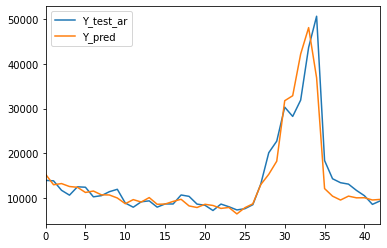

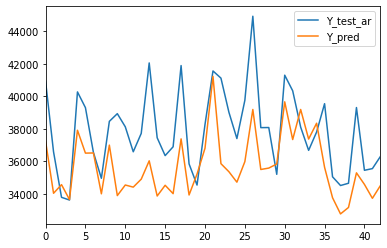

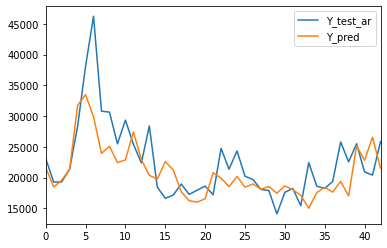

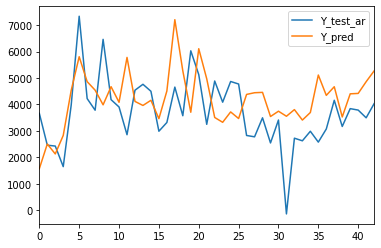

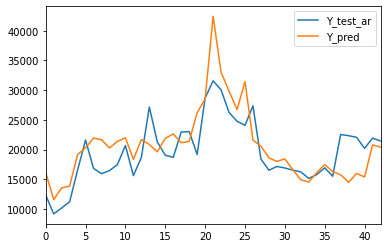

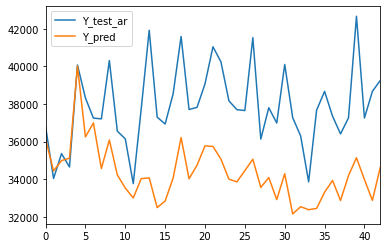

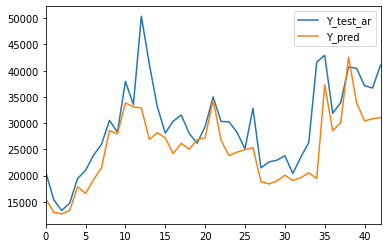

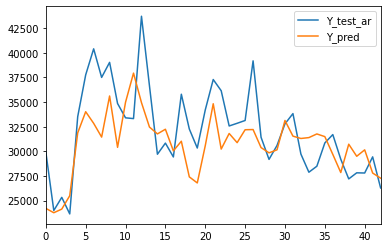

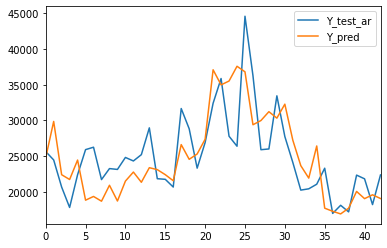

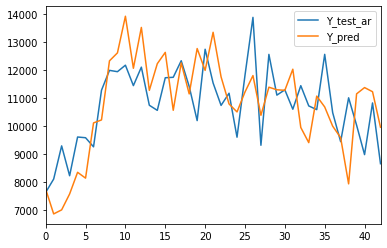

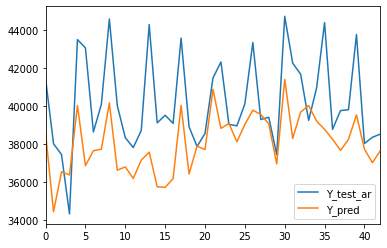

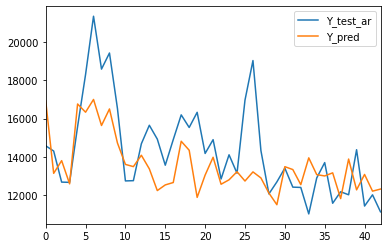

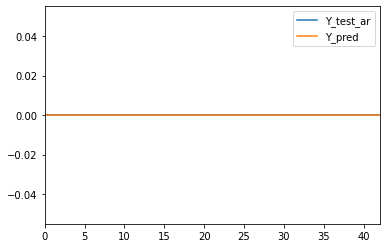

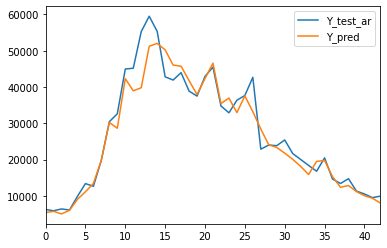

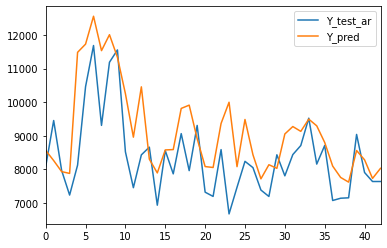

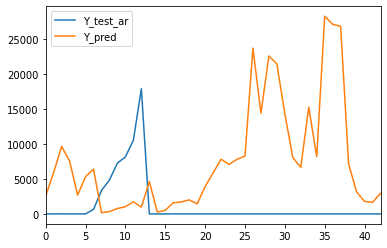

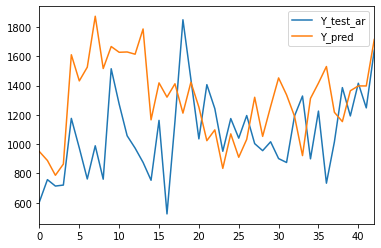

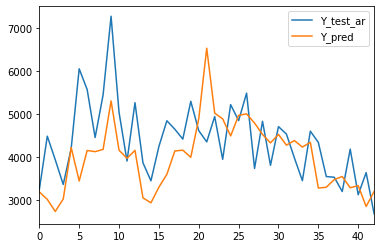

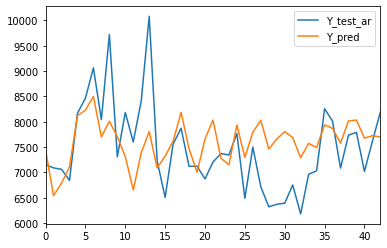

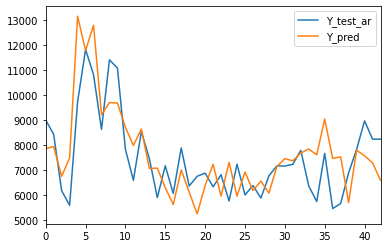

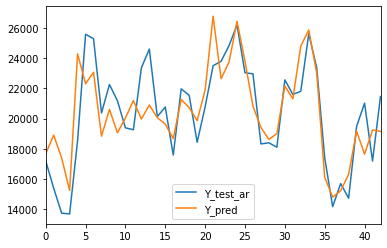

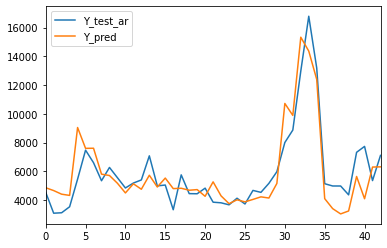

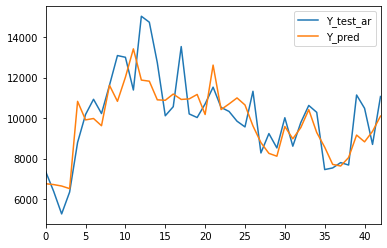

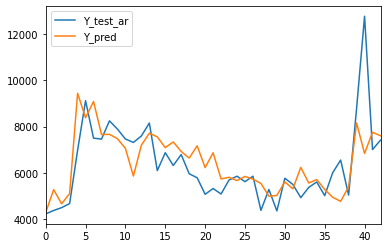

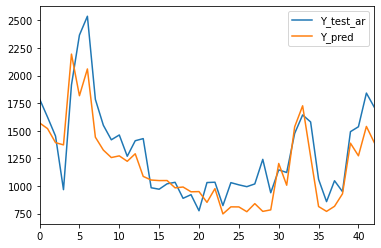

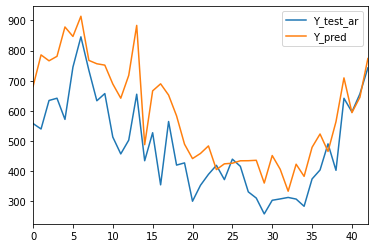

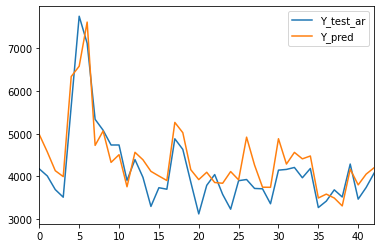

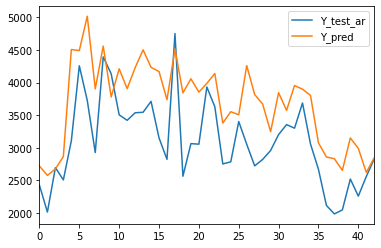

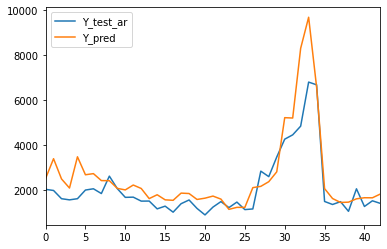

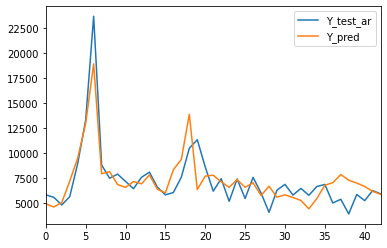

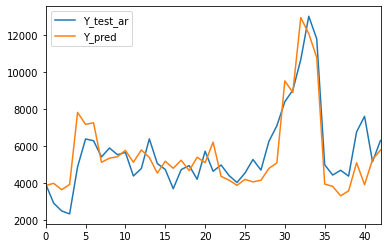

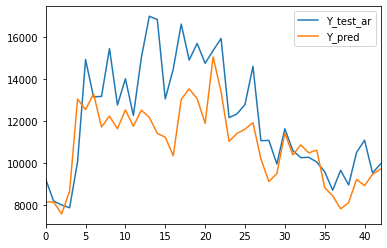

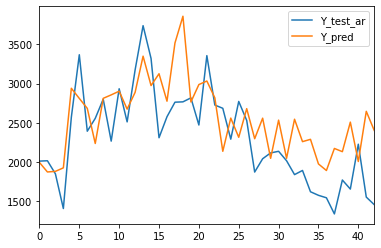

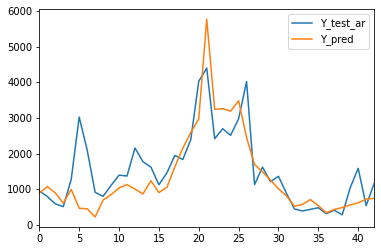

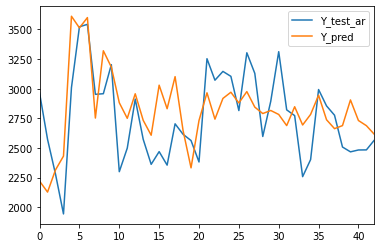

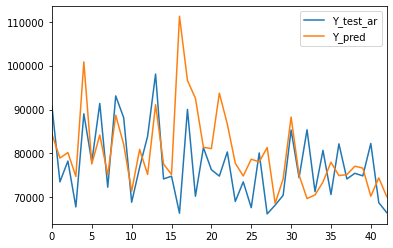

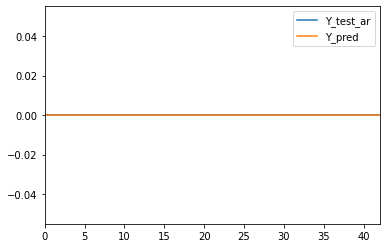

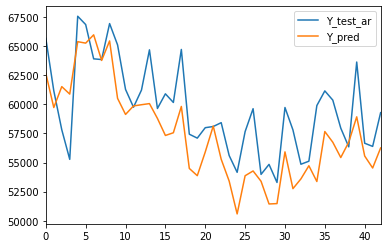

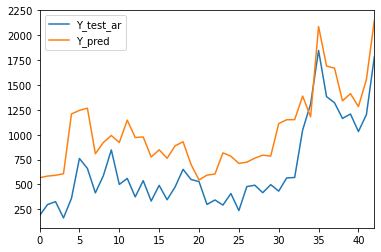

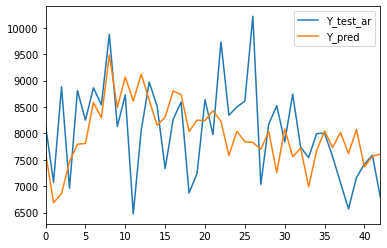

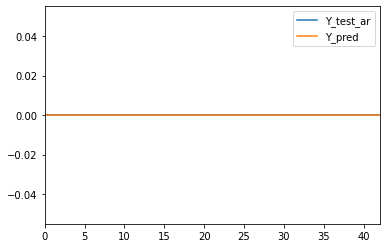

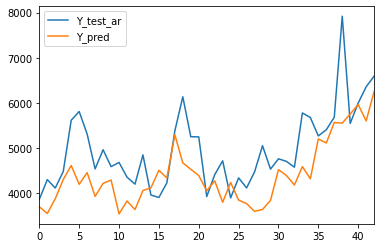

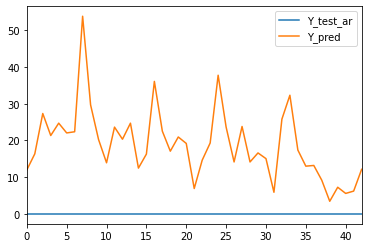

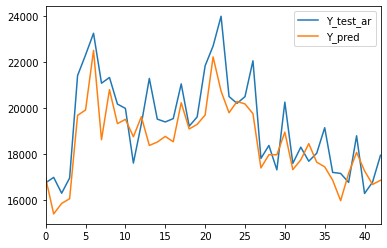

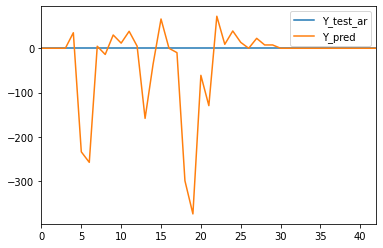

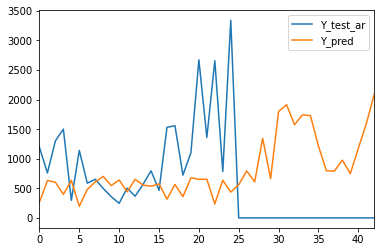

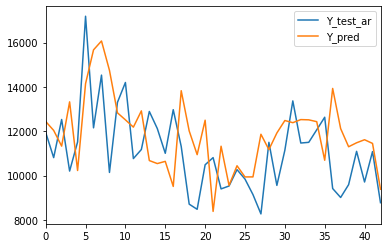

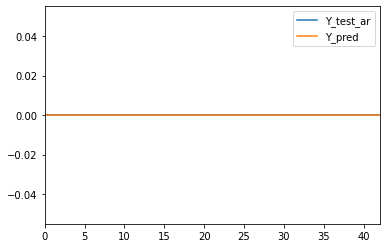

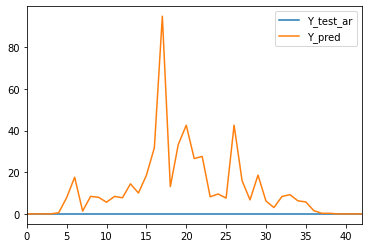

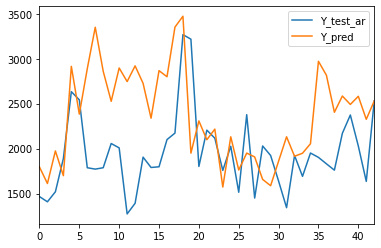

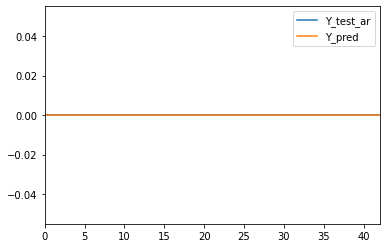

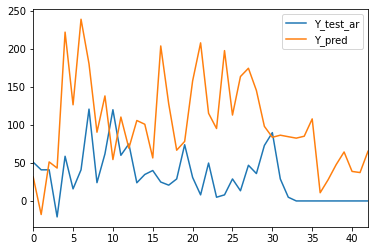

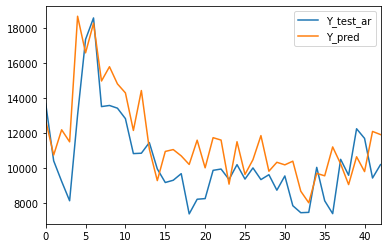

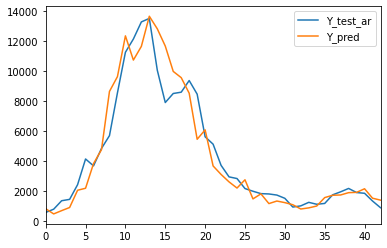

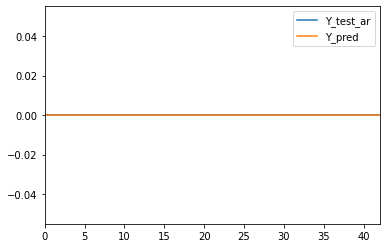

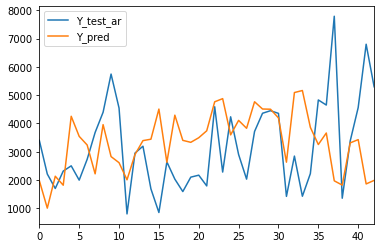

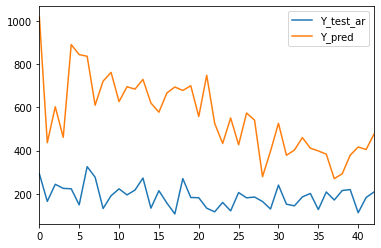

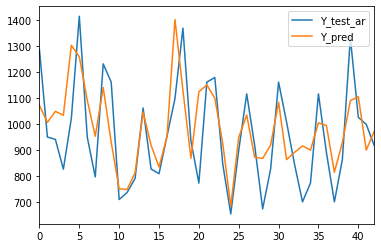

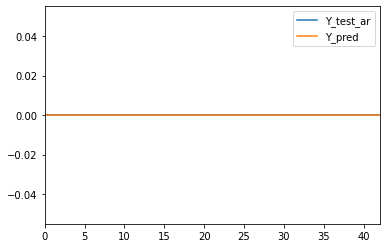

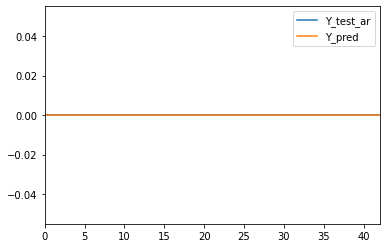

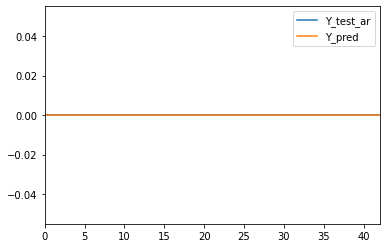

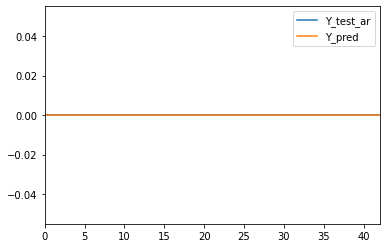

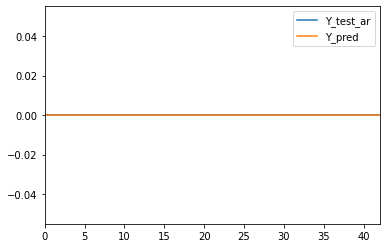

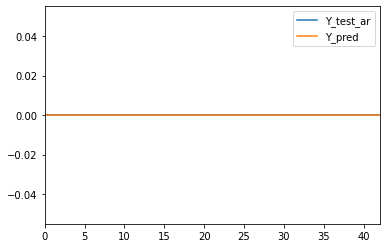

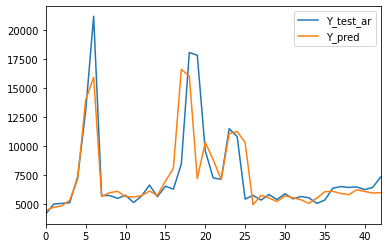

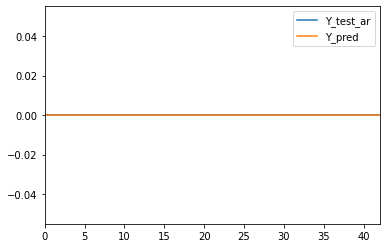

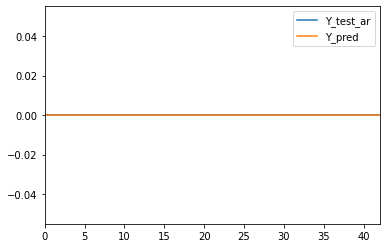

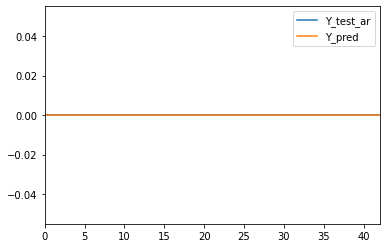

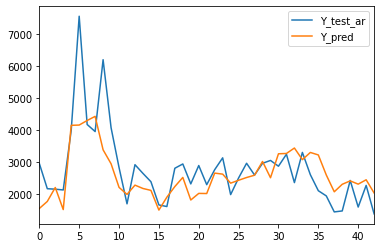

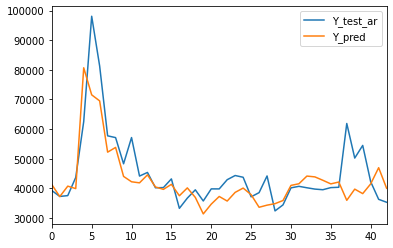

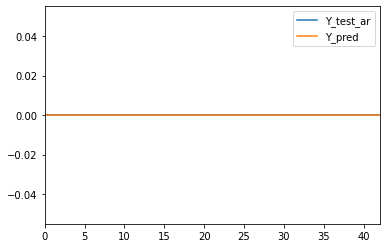

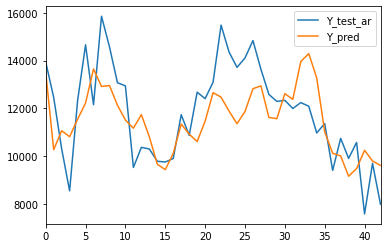

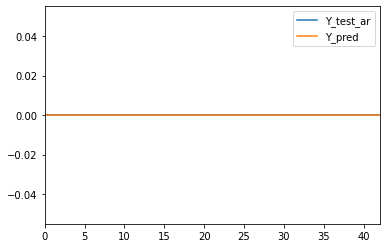

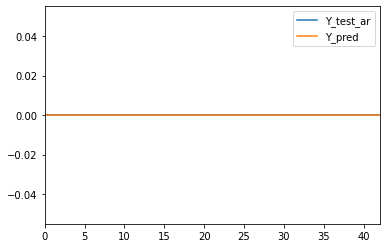

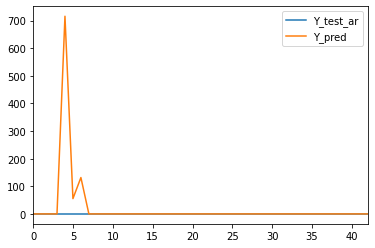

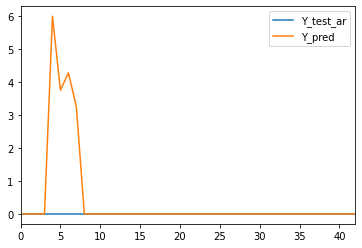

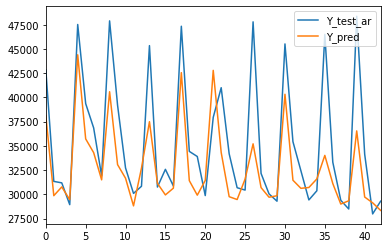

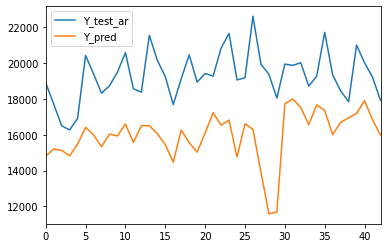

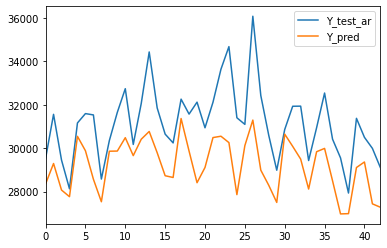

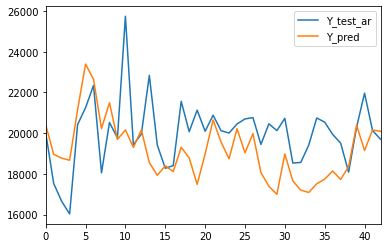

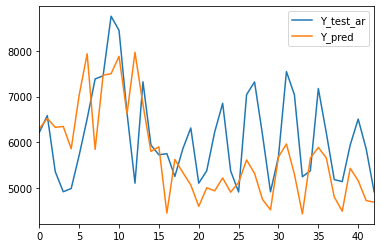

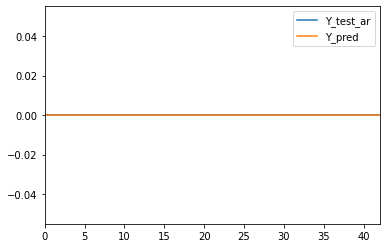

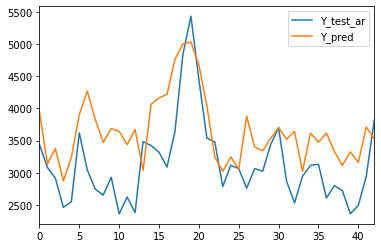

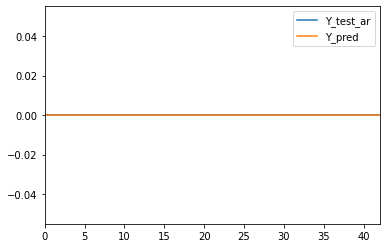

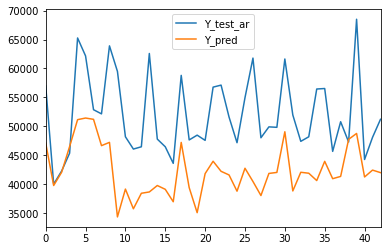

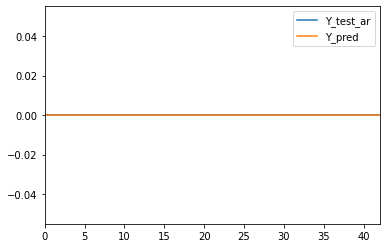

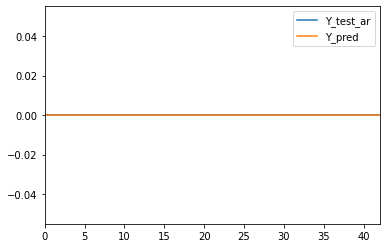

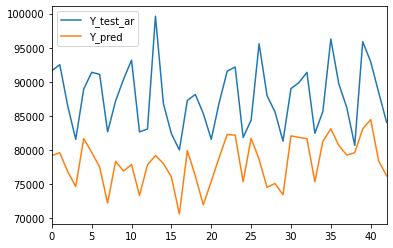

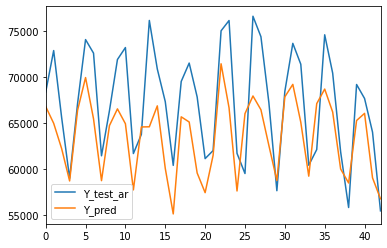

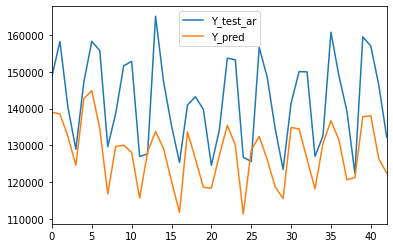

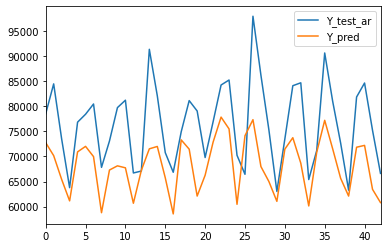

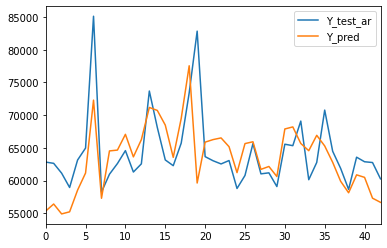

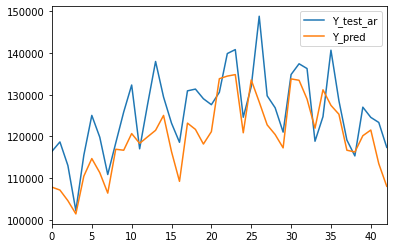

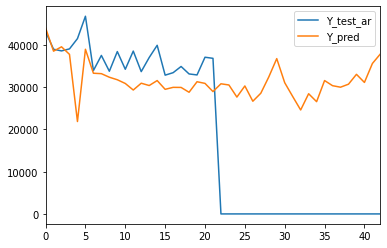

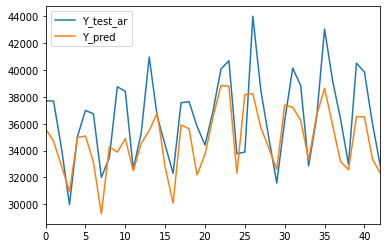

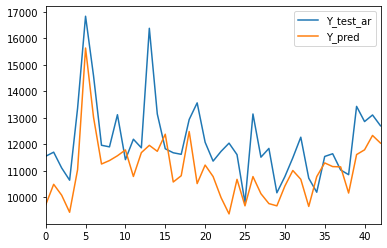

In [123]:
for i in range(2,98):
    Y_graph = pd.DataFrame({'Y_test_ar': Y_test_ar[:,i], 'Y_pred':Y_pred[:,i]})
    Y_graph.plot()

# 時系列分析

In [26]:
# 基本のライブラリを読み込む
import numpy as np
import pandas as pd
from scipy import stats

# グラフ描画
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline
sns.set()

# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# 統計モデル
import statsmodels.api as sm

In [27]:
store1_1_tra_b = store1_1_tra[['Date','Weekly_Sales']]

In [28]:
store1_1_tra_b.head()

,Date,Weekly_Sales
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90


In [74]:
ts = store1_1_tra_b['Weekly_Sales']

In [41]:
ts.shape

(143,)

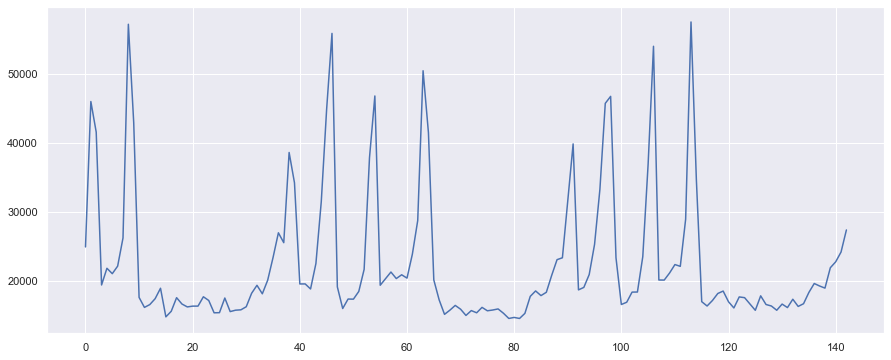

In [30]:
plt.plot(ts)

In [75]:
# 自己相関を求める
ts_acf = sm.tsa.stattools.acf(ts, nlags=40)
ts_acf

C:\Users\81907\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:669: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


array([ 1.        ,  0.56126262,  0.11951928, -0.02221244, -0.06217717,
       -0.03899788,  0.10609105,  0.36408559,  0.36314566,  0.16847294,
        0.03265583, -0.09913963, -0.16718372, -0.17160128, -0.11652486,
        0.00972655, -0.01018362, -0.03243171, -0.05847488, -0.15212162,
       -0.21104998, -0.23072635, -0.17865402, -0.17531277, -0.17611628,
       -0.16089338, -0.1570411 , -0.13552905, -0.13071364, -0.14741416,
       -0.13580843, -0.15846856, -0.16774822, -0.13068171, -0.07322534,
       -0.05635629, -0.00595454,  0.08326365, -0.00363709, -0.14391893,
       -0.14182782])

In [37]:
# 偏自己相関
ts_pacf = sm.tsa.stattools.pacf(ts, method='ols')
ts_pacf

C:\Users\81907\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1027: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,


array([ 1.        ,  0.56223343, -0.28337671,  0.07951106, -0.0756523 ,
        0.03966526,  0.17252463,  0.32019877, -0.04973371, -0.02043137,
        0.01244517, -0.14018953, -0.03974008, -0.10438062, -0.12971139,
        0.01994521, -0.16031023,  0.03439323, -0.02251533, -0.07567511,
       -0.02837734, -0.05061999, -0.06479797, -0.12075792, -0.06014284,
       -0.17507762, -0.03167559, -0.03617202, -0.06742501, -0.04675356,
       -0.01791472, -0.1207839 , -0.06701925, -0.05108646, -0.07700249,
       -0.17141376,  0.07539556,  0.03375092, -0.29835897, -0.21220646,
       -0.11811078])

C:\Users\81907\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


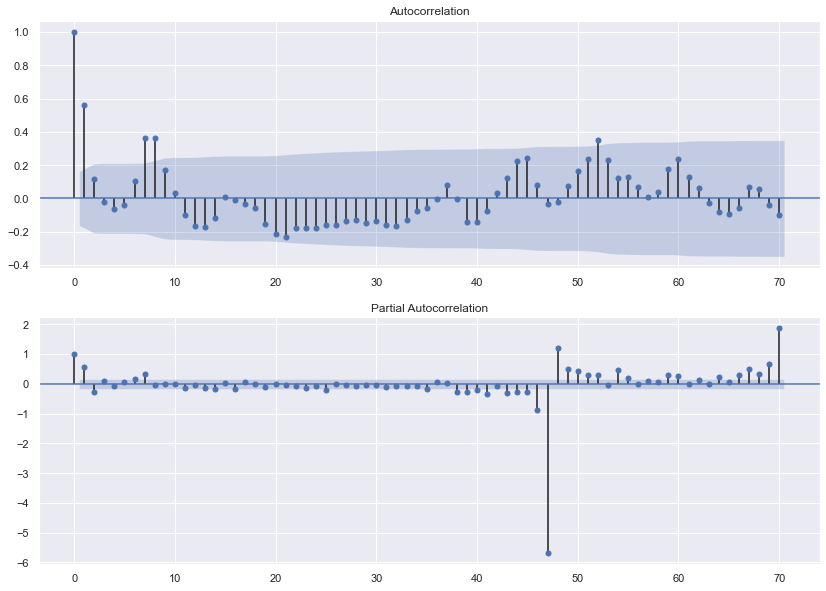

In [63]:
#  自己相関と偏自己相関のグラフ
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=70, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=70, ax=ax2)

データの分割

In [65]:
train_rows = 100
ts_train = ts[:train_rows]
ts_test = ts[train_rows:]

In [66]:
print(ts_train.shape)
print(ts_test.shape)

(100,)
(43,)


ARIMA関数を適用してみる

In [76]:
# 次数は適当
from statsmodels.tsa.arima_model import ARIMA
ARIMA_3_1_2 = ARIMA(ts_train, order=(3, 1, 2)).fit(dist=False)
ARIMA_3_1_2.params

C:\Users\81907\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


const                   50.845114
ar.L1.D.Weekly_Sales    -0.335085
ar.L2.D.Weekly_Sales     0.263594
ar.L3.D.Weekly_Sales    -0.401179
ma.L1.D.Weekly_Sales     0.173893
ma.L2.D.Weekly_Sales    -0.826107
dtype: float64

In [84]:
ts_train.head()

0    24924.50
1    46039.49
2    41595.55
3    19403.54
4    21827.90
Name: Weekly_Sales, dtype: float64

In [83]:
ts_test.tail()

138    18947.81
139    21904.47
140    22764.01
141    24185.27
142    27390.81
Name: Weekly_Sales, dtype: float64

In [91]:
# 予測する
pred = ARIMA_3_1_2.predict('2010-02-05','2012-10-26')

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

# Prophetによる時系列予測

In [25]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'